## Imports

In [2095]:
import pandas as pd
import requests
from urllib.request import Request, urlopen    
from pandas.api.types import is_datetime64_any_dtype as is_datetime
from datetime import datetime
import math
import matplotlib.pyplot  as plt
import tabula
from tabula.io import read_pdf
from statistics import mean
import numpy as np
from scipy import stats
import seaborn as sns



# Acquisition

### Helper functions

In [2046]:
#A function that returns a dataframe of all the historic data of a given ticker. 
def get_yfinance_data(ticker):
	url = f'https://query1.finance.yahoo.com/v7/finance/download/{ticker}?period1=994016928&period2=1642982400&interval=1d&events=history&includeAdjustedClose=true'

	data = pd.read_csv(url)

	return data

### Retrieval

In [2047]:
#Get crypto historic prices
df_btc_usd = get_yfinance_data('BTC-USD')
df_eth_usd = get_yfinance_data('ETH-USD')
df_sol_usd = get_yfinance_data('SOL1-USD')
df_ada_usd = get_yfinance_data('ADA-USD')
df_doge_usd = get_yfinance_data('DOGE-USD')
df_xrp_usd = get_yfinance_data('XRP-USD')


In [2048]:
crypto_dfs = [df_sol_usd, df_ada_usd, df_doge_usd, df_eth_usd, df_xrp_usd]

In [2049]:
#Get SOXX historic prices
df_soxx = get_yfinance_data('SOXX')

In [2050]:
#Get Crude oil prices
df_oil = get_yfinance_data('CL=F')

In [2051]:
#Get cloud companies (server providers) ETF prices
df_servers = get_yfinance_data('SKYY')

In [2052]:
#Get US wildfires
df_wildfires = pd.read_csv("https://www.ncdc.noaa.gov/societal-impacts/wildfires/ytd/0/data.csv", skiprows=1)

In [2053]:
df_divorce = tabula.read_pdf('https://www.cdc.gov/nchs/data/dvs/national-marriage-divorce-rates-00-19.pdf', pages=1)[0]

In [2054]:
#Get Nicolas Cage data
url = 'https://imdb-api.com/API/Name/k_vt8o65n8/nm0000115'
resp = requests.get(url)
nc_data = resp.json()
df_nicolas = pd.DataFrame(nc_data['castMovies'])


In [2055]:
#Get GHG emmissions in Europe
#source https://ourworldindata.org/co2-emissions
df_ghg = pd.read_csv('datasets/annual-co2-emissions-per-country.csv')

In [2056]:
#Get energy conspumption in Europe in kWh
#source https://ourworldindata.org/grapher/primary-energy-cons?tab=chart&time=2000..latest&country=~Europe
df_nrg = pd.read_csv('datasets/primary-energy-cons.csv')

In [2057]:
#Get renewable energy share of total energy consumption
df_renewable = pd.read_csv('datasets/nrg_ind_ren_page_linear.csv')

In [2058]:
#Get renewable energy production of total production
df_renewable_prod = pd.read_csv('datasets/share-elec-by-source.csv')

# Wrangling

### Helper functions

In [2059]:
#Function that returns the oldest data from a list of data frames. 
def str_to_datetime(dataframes, date_column):
	for df in dataframes:
		df[date_column] = pd.to_datetime(df[date_column]).dt.date

#Function that returns the first date of the "youngest" of dataframes
def get_min_possible_date(dataframes, date_column):

	return max([min(dataframe[date_column]) for dataframe in dataframes])


#DONT USE, Function that returns the oldest date along with the name of the df that contains it
def get_oldest_df(dataframes, date_column):
	ol_date = (get_min_possible_date(dataframes, date_column), 42)
	for i, df in enumerate(dataframes):
		first_entry = min(df[date_column])
		if first_entry < ol_date[0]:
			ol_date = (first_entry, i)
	
	return ol_date[0], dataframes[ol_date[1]]

def clear_years(data): ## remove extra note on year strings
	if len(data) > 4:
		data = data[0:4]

	return data

### Crypto Index

We know that bitcoin is the oldest cryptocurrency so we can calculate the index with it as a base

In [2060]:
#Clean data to just the variables we need
df_btc_usd = df_btc_usd[['Date', 'Close', 'Volume']].rename({'Close': 'BTC_price', 'Volume': 'BTC_vol'}, axis=1)
df_eth_usd = df_eth_usd[['Date', 'Close', 'Volume']].rename({'Close': 'ETH_price', 'Volume': 'ETH_vol'}, axis=1)
df_sol_usd = df_sol_usd[['Date', 'Close', 'Volume']].rename({'Close': 'SOL_price', 'Volume': 'SOL_vol'}, axis=1)
df_ada_usd = df_ada_usd[['Date', 'Close', 'Volume']].rename({'Close': 'ADA_price', 'Volume': 'ADA_vol'}, axis=1)
df_doge_usd = df_doge_usd[['Date', 'Close', 'Volume']].rename({'Close': 'DOGE_price', 'Volume': 'DOGE_vol'}, axis=1)
df_xrp_usd = df_xrp_usd[['Date', 'Close', 'Volume']].rename({'Close': 'XRP_price', 'Volume': 'XRP_vol'}, axis=1)


In [2061]:
#Create new Dataframe inlcuding all cryptocurrencies closing prices and volumes
cr_index = df_btc_usd
cr_index = cr_index.merge(df_eth_usd, on='Date', how='left')
cr_index = cr_index.merge(df_ada_usd, on='Date', how='left')
cr_index = cr_index.merge(df_xrp_usd, on='Date', how='left')
cr_index = cr_index.merge(df_doge_usd, on='Date', how='left')
cr_index = cr_index.merge(df_sol_usd, on='Date', how='left')

In [2062]:
#Turn "Date" column to datetime format instead of str
str_to_datetime([cr_index], 'Date')

#Fill NaNs with 0
cr_index = cr_index.fillna(0)

#Calculate total trading volume per day
cr_index['tot_volume'] = cr_index[['BTC_vol', 'ETH_vol', 'ADA_vol', 'XRP_vol', 'DOGE_vol', 'SOL_vol']].sum(axis=1)

In [2063]:
cr_index.columns

Index(['Date', 'BTC_price', 'BTC_vol', 'ETH_price', 'ETH_vol', 'ADA_price',
       'ADA_vol', 'XRP_price', 'XRP_vol', 'DOGE_price', 'DOGE_vol',
       'SOL_price', 'SOL_vol', 'tot_volume'],
      dtype='object')

In [2064]:

def index_calc(df):

	return math.log10(sum([(df['BTC_price']*(df['BTC_vol']/df['tot_volume'])),
			  (df['ETH_price']*(df['ETH_vol']/df['tot_volume'])),
			  (df['ADA_price']*(df['ADA_vol']/df['tot_volume'])),
			  (df['XRP_price']*(df['XRP_vol']/df['tot_volume'])),
			  (df['DOGE_price']*(df['DOGE_vol']/df['tot_volume'])),
			  (df['SOL_price']*(df['SOL_vol']/df['tot_volume']))]))

cr_index['Crypto_Index'] = cr_index.apply(index_calc, axis=1)
cr_index = cr_index[['Date', 'Crypto_Index']]
cr_index['Date'] = pd.to_datetime(cr_index['Date'])
cr_index = cr_index.set_index(cr_index['Date'])
cr_index = cr_index[['Crypto_Index']]
cr_index = cr_index.groupby(cr_index.index.year).agg('mean')

<AxesSubplot:xlabel='Date'>

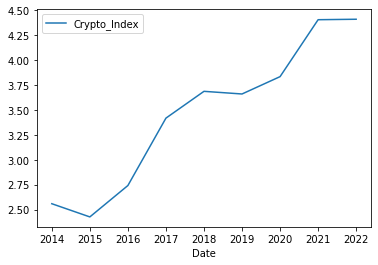

In [2065]:
cr_index.plot()

### Other indices

In [2066]:
#Finance dataframes to datetime format
df_soxx['Date'] = pd.to_datetime(df_soxx['Date'])
df_oil['Date'] = pd.to_datetime(df_oil['Date'])
df_servers['Date'] = pd.to_datetime(df_servers['Date'])

In [2067]:
#Wildfires prep
df_wildfires['Date'] = pd.to_datetime(df_wildfires['Date'], format="%Y%m")

In [2068]:
df_divorce.rename(columns=df_divorce.iloc[1], inplace=True) #column names were perceived as a row, turn the into actual column names
df_divorce = df_divorce.iloc[2:, :] # delete first 2 rows of no data
df_divorce = df_divorce.reset_index().drop('index',axis=1) # drop old index after reset
df_divorce['Year'] = df_divorce['Year'].apply(clear_years) #clear year data strings from unwanted extra note
df_divorce.rename(columns={'Year': 'Date'}, inplace=True) # change name for consistency
df_divorce['Date'] = pd.to_datetime(df_divorce['Date'], format='%Y')
df_divorce.replace(',', '', inplace=True, regex=True) #remove commas from number strings so we an turn them into int
df_divorce[['Marriages', 'Population', 'population']] = df_divorce[['Marriages', 'Population', 'population']].apply(pd.to_numeric) #turn str numbers into int

In [2069]:
#Nicolas Cage prep
df_nicolas = df_nicolas[df_nicolas['role'] == "Actor"] #Keep only movies where he was an actor
df_nicolas = df_nicolas[['year', 'title', 'description']] # drop redundant columns and change order
df_nicolas = df_nicolas[df_nicolas['year'] != ''] #drop that haven't been released yet
df_nicolas.rename(columns={'year': 'Date'}, inplace=True) #rename year column for consistency
df_nicolas['Date'] = df_nicolas['Date'].apply(clear_years) #Clear years for notes and extra chars
df_nicolas['Date'] = pd.to_datetime(df_nicolas['Date']) #str to datetime for Years column
df_nicolas = df_nicolas.sort_values('Date', ascending=False) #sort new to old
df_nicolas = df_nicolas.reset_index().drop('index',axis=1) # drop old index after reset
df_nicolas = pd.DataFrame(df_nicolas['title'].groupby(df_nicolas['Date']).agg('count') ) #get number of movies per year
df_nicolas.reset_index(inplace=True) #reset the idex for consistency
df_nicolas.rename(columns={'title': 'no. of movies'}, inplace=True) #change name for clarity

In [2070]:
#GHG prep
df_ghg = df_ghg[df_ghg['Entity'] == 'Europe'] # Select only europe
df_ghg = df_ghg[df_ghg['Year'] >= 2000] # Select data only form 2000 and beyond
df_ghg.rename(columns={'Year':'Date', 'Annual CO2 emissions':'Value(tn)'}, inplace=True) #Change columns name values for consistency
df_ghg['Date'] = pd.to_datetime(df_ghg['Date'], format='%Y') #Date from str to datetime
df_ghg = df_ghg.reset_index().drop('index',axis=1) #reset and clear index
df_ghg = df_ghg[['Date', 'Value(tn)']] #keep only relevant columns

In [2071]:
#Energy consumption prep
df_nrg = df_nrg[df_nrg['Entity'] == 'Europe'] # Select only europe
df_nrg = df_nrg[df_nrg['Year'] >= 2011] # Select data only form 2000 and beyond
df_nrg.rename(columns={'Year':'Date', 'Primary energy consumption (TWh)':'Value(TWh)'}, inplace=True) #Change columns name values for consistency
df_nrg['Date'] = pd.to_datetime(df_nrg['Date'], format='%Y') #Date from str to datetime
df_nrg = df_nrg.reset_index().drop('index',axis=1) #reset and clear index
df_nrg = df_nrg[['Date', 'Value(TWh)']] #keep only relevant columns
df_nrg['Date'] = df_nrg['Date'].dt.year
df_nrg = df_nrg.set_index('Date')
df_nrg

,Value(TWh)
Date,
2011,24071.279
2012,23977.085
2013,23729.439
2014,22806.380
2015,22992.401
2016,23305.822
2017,23543.516
2018,23543.272
2019,23282.096


In [2072]:
#Renewables consumption prepprep
#drop everything but countries 

df_renewable.drop(df_renewable[df_renewable['geo'] == 'EU27_2020'].index, inplace = True) 
df_renewable.drop(df_renewable[df_renewable['geo'] == 'EA19'].index, inplace = True)
a = (df_renewable.groupby(['TIME_PERIOD','OBS_VALUE'],as_index = False)['OBS_VALUE'].mean().groupby('TIME_PERIOD').mean()).reset_index()
a['TIME_PERIOD'] = pd.to_datetime(a['TIME_PERIOD'], format='%Y')
a.rename(columns={'TIME_PERIOD': 'Date', 'OBS_VALUE': 'avg_share'}, inplace=True)
df_renewable = a

df_renewable['Date'] = df_renewable['Date'].dt.year
df_renewable = df_renewable.set_index('Date')
df_renewable = df_renewable[df_renewable.index < 2020]
df_renewable['avg_share'] = df_renewable['avg_share'] / 100
df_renewable['renew_from_total'] = (df_renewable['avg_share'] * df_nrg['Value(TWh)']).astype('int')
df_renewable = df_renewable[['renew_from_total']]
df_renewable

,renew_from_total
Date,
2011,4955
2012,5233
2013,5376
2014,5372
2015,5524
2016,5666
2017,5774
2018,6003
2019,6110


## Combine data into index

In [2073]:
cr_index = cr_index[cr_index.index >= 2014]
cr_index = cr_index[cr_index.index < 2020]
cr_index

,Crypto_Index
Date,
2014,2.559234
2015,2.426660
2016,2.741805
2017,3.418463
2018,3.687590
2019,3.660965


In [2074]:
df_ghg['Date'] = df_ghg['Date'].dt.year
df_ghg = df_ghg.set_index(df_ghg['Date'])
df_ghg = df_ghg.drop('Date', axis=1)
df_ghg = df_ghg[df_ghg.index >= 2014]
df_ghg = df_ghg[df_ghg.index < 2020]

df_nrg = df_nrg[df_nrg.index >= 2014]
df_nrg = df_nrg[df_nrg.index < 2020]

df_renewable = df_renewable[df_renewable.index >= 2014]
df_renewable = df_renewable[df_renewable.index < 2020]

In [2075]:
df_ghg

,Value(tn)
Date,
2014,5589757324
2015,5594384221
2016,5590252902
2017,5620306625
2018,5593057381
2019,5430238970


In [2076]:
climate_index = df_ghg
climate_index = climate_index.merge(df_renewable, left_index=True, right_index=True)
climate_index = climate_index.merge(df_nrg, left_index=True, right_index=True)

In [2077]:
# climate_index['Value(tn)'] = climate_index['Value(tn)'] /2
# climate_index['renew_from_total'] = climate_index['renew_from_total'] * 0.25
# climate_index['Value(TWh)'] = climate_index['Value(TWh)'] * 0.25

In [2078]:
def indexize(df):
	s = sum([df['Value(tn)']*0.50, df['renew_from_total']*0.25, df['Value(TWh)']*0.25])
	return math.log10(s)
	
climate_index['Index'] = climate_index.apply(indexize, axis=1)
climate_index 

,Value(tn),renew_from_total,Value(TWh),Index
Date,,,,
2014,5589757324,5372,22806.380,9.446364
2015,5594384221,5524,22992.401,9.446723
2016,5590252902,5666,23305.822,9.446403
2017,5620306625,5774,23543.516,9.448731
2018,5593057381,6003,23543.272,9.446620
2019,5430238970,6110,23282.096,9.433790


In [2079]:
climate_index

,Value(tn),renew_from_total,Value(TWh),Index
Date,,,,
2014,5589757324,5372,22806.380,9.446364
2015,5594384221,5524,22992.401,9.446723
2016,5590252902,5666,23305.822,9.446403
2017,5620306625,5774,23543.516,9.448731
2018,5593057381,6003,23543.272,9.446620
2019,5430238970,6110,23282.096,9.433790


In [2080]:
cr_index

,Crypto_Index
Date,
2014,2.559234
2015,2.426660
2016,2.741805
2017,3.418463
2018,3.687590
2019,3.660965


<AxesSubplot:xlabel='Date'>

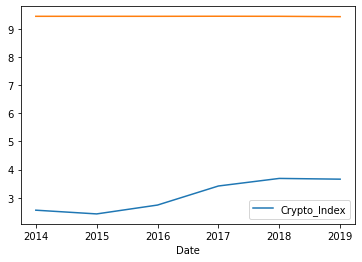

In [2081]:
cr_index.plot()
climate_index['Index'].plot()

In [2085]:
stats.pearsonr(cr_index['Crypto_Index'], climate_index['Index'])

(-0.42169867237987035, 0.4049472804500055)

In [2091]:
corel = cr_index
corel = corel.merge(climate_index['Index'], left_index=True, right_index=True)


In [2097]:
corel.corr()

,Crypto_Index,Index
Crypto_Index,1.000000,-0.421699
Index,-0.421699,1.000000
